In [ ]:
!pip install qiskit
!pip install qiskit_ibm_runtime
!pip install pylatexenc
!pip install qiskit-aer

In [3]:
from qiskit.quantum_info import Operator
from qiskit import QuantumCircuit
import numpy as np

In [36]:
def diffuser(n,theta,name='V'):
  n = n+1
  zstr = '0'*(n-1)
  qc = QuantumCircuit(n, name=name)
  qc.h(range(n-1))
  qc.ry(-theta,n-1)
  qc.x(n-1)
  qc.h(n-1)
  qc.mcx(list(range(n-1)),n-1,ctrl_state=zstr)
  qc.h(n-1)
  qc.x(n-1)
  qc.h(range(n-1))
  qc.ry(theta,n-1)
  return qc

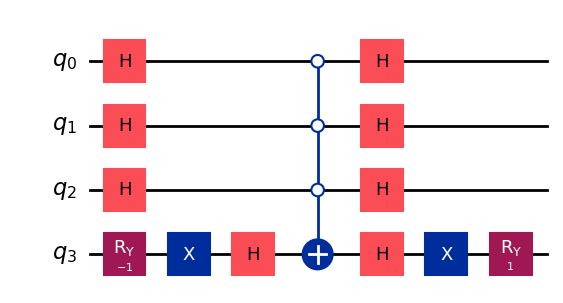

In [37]:
check = diffuser(3,1)
check.draw('mpl')

In [38]:
def phase_oracle(n, marked, name = 'Uf'):
  n = n+1
  qc = QuantumCircuit(n, name=name)
  qc.h(n-1)
  qc.mcx(list(range(n-1)),n-1,ctrl_state=marked)
  qc.h(n-1)
  return qc

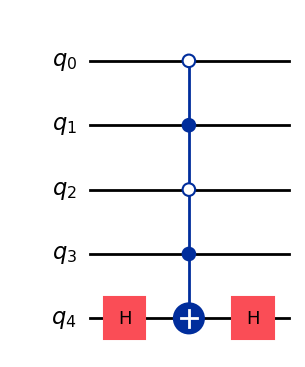

In [39]:
c = phase_oracle(4,'1010')
c.draw('mpl')

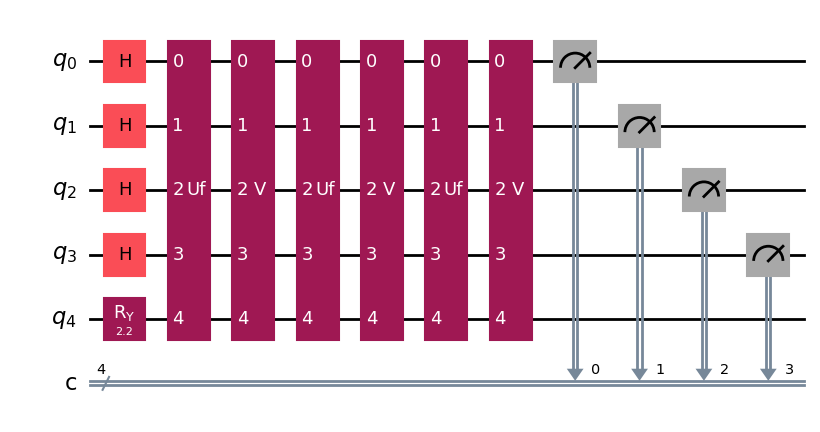

In [43]:
n=4
marked = '1001'
gr = QuantumCircuit(n+1, n)
nsol=1 #number of solutions
alpha=np.arcsin(np.sqrt(nsol/2**(n))) # Determine alpha
rp = round(np.pi/(4*alpha)-0.5) # Determine r
alphap = np.pi/(4*(rp+0.5))
theta = 2*np.arcsin(np.sin(alphap)/np.sin(alpha))

gr.h(range(n))    # step 1: apply Hadamard gates on all working qubits
gr.ry(theta,n)

# step 2: apply r rounds of the phase oracle and the diffuser
for j in range(rp):
    gr.append(phase_oracle(n,marked), range(n+1))
    gr.append(diffuser(n,theta), range(n+1))

gr.measure(range(n), range(n))    # step 3: measure all qubits

gr.draw('mpl')

PrimitiveResult([SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=1000, num_bits=4>)), metadata={'shots': 1000, 'circuit_metadata': {}})], metadata={'version': 2})


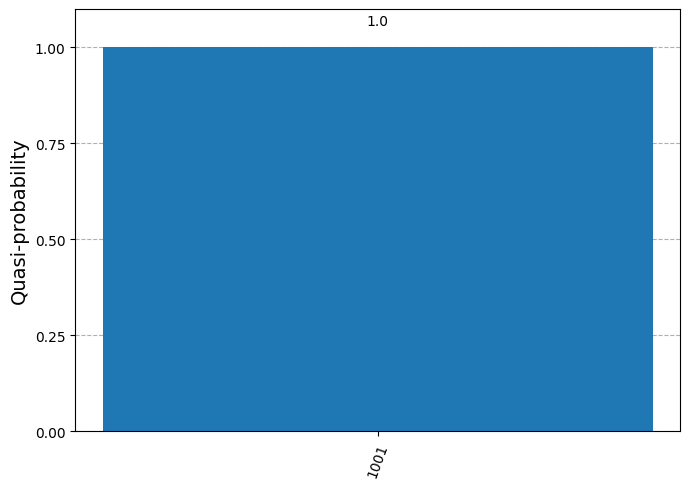

In [44]:
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_aer import AerSimulator
from qiskit import transpile
simulator_aer=AerSimulator()
gr_trsp = transpile(gr, simulator_aer)
sampler_aer = Sampler(simulator_aer)
job = sampler_aer.run([(gr_trsp, None,1000)])
result =  job.result()
print(result)
counts = result[0].data.c.get_counts()
from qiskit.visualization import plot_histogram, plot_distribution

plot_distribution(counts)

In [45]:
# PUBs on IBM quantum computers
from qiskit_ibm_runtime import QiskitRuntimeService
token = "nDLD07y8TqS3jvE-zdQ3RFLExYFd4E89wPIw4qV_tclN"
QiskitRuntimeService.save_account(
  token=token,
  channel="ibm_quantum_platform", # `channel` distinguishes between different account types.
  instance="crn:v1:bluemix:public:quantum-computing:us-east:a/2f903a94d6564bb2a042b9d46bda122d:6c4b797f-5ec9-4077-b5fa-bf87972e20d0::", # Optionally copy the instance CRN or name from the Instance section on the dashboard.
  name="Faryad-free-ibm", # Optionally name this set of credentials.
  overwrite=True # Only needed if you already have Cloud credentials.
)

In [46]:
# Load saved credentials if you specified a name
ibm_service = QiskitRuntimeService(name="Faryad-free-ibm")
ibmq_comp = ibm_service.backend('ibm_torino')

from qiskit_ibm_runtime import SamplerV2
sampler_ibm = SamplerV2(mode=ibmq_comp)

qc_tr_ibm = transpile(gr, backend = ibmq_comp)

job_ibm = sampler_ibm.run([(qc_tr_ibm,None,1000)]) #PUB = (circuit, paramters, shots)
print(job_ibm.job_id())

d1l6lmna572c73970n80


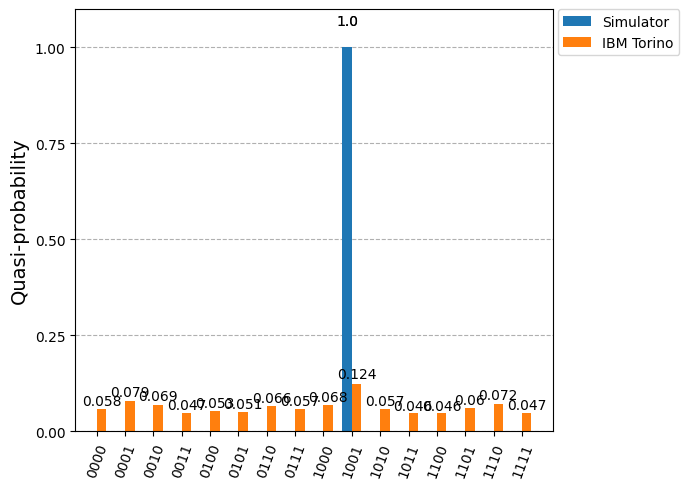

In [47]:
job = ibm_service.job('d1l6lmna572c73970n80')
result = job.result()
counts_ibm = result[0].data.c.get_counts()
from qiskit.visualization import plot_histogram, plot_distribution

plot_distribution([counts,counts_ibm], legend = ['Simulator', 'IBM Torino'])